# Load Modules

In [1]:
%pylab inline

import numpy  as np
import pandas  as pd
import os
import random
import tensorflow as tf
from keras import backend as K

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


This notebook requires the [Keras](https://keras.io/) module. You can install it with the shell command `pip install keras`.

In [2]:
from keras.models     import Sequential
from keras.layers     import Activation
from keras.optimizers import SGD
from keras.layers     import Dense
from keras.utils      import to_categorical
from keras.datasets   import mnist
from keras.metrics    import categorical_accuracy
from keras.callbacks  import EarlyStopping

In [3]:
# Set the Random Seed
seed_value= 2020

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

The module [seaborn](http://seaborn.pydata.org/) is **not** necessary. Just for nicer plots, install it with `pip install seaborn`.

In [4]:
import seaborn as sns
sns.set(style='white', font_scale=1.3, rc={
    'lines.linewidth': 3,
    'axes.grid': True, 'grid.linestyle': ':',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'axes.edgecolor': '.5',
})

# Load MNIST Dataset

In [5]:
(x_trai, y_trai), (x_test, y_test) = mnist.load_data()

In [6]:
L_trai = len(x_trai)
L_test = len(x_test)

# Reshape the images into vectors of dim 28*28=784
X_trai = x_trai.reshape((L_trai, -1))
X_test = x_test.reshape((L_test, -1))

# Y needs to be converted into a vector with indicators
Y_test = to_categorical(y_test)
Y_trai = to_categorical(y_trai)

print("We have {0:0,.0f} samples in the training set".format(L_trai))
print("We have {0:0,.0f} samples in the test set".format(L_test))

We have 60,000 samples in the training set
We have 10,000 samples in the test set


## Plot some random digits

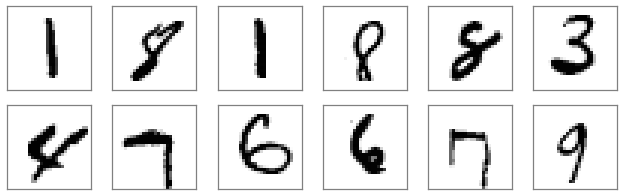

In [7]:
NX, NY = 2, 6
fig, ax = plt.subplots(NX,NY,figsize=(1.5*NY,1.5*NX))
for i in range(NX):
    for j in range(NY):
        img = x_trai[np.random.randint(L_trai)]
        ax[i][j].imshow(img, cmap='Greys');
        ax[i][j].set_xticklabels([]); ax[i][j].set_xticks([])
        ax[i][j].set_yticklabels([]); ax[i][j].set_yticks([])
plt.tight_layout()
#plt.savefig("digits_examples.pdf")

# Shallow Neural Network
Only one hidden layer

In [8]:
# Define the shallow neural network

model = Sequential(name='Shallow Network')

model.add(Dense(50, activation="relu", name='Hidden_Layer_1', input_dim=784))

model.add(Dense(10, name="Output_Layer"))                  # 10 is the output dimension
model.add(Activation("softmax", name='Output_Activation')) # Provides probabilities for each of 0,..,9

model.compile(loss="categorical_crossentropy", optimizer=SGD(clipnorm=1), metrics=[categorical_accuracy]  )

In [9]:
model.summary()

Model: "Shallow Network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer_1 (Dense)       (None, 50)                39250     
_________________________________________________________________
Output_Layer (Dense)         (None, 10)                510       
_________________________________________________________________
Output_Activation (Activatio (None, 10)                0         
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Train the shallow neural network
history = model.fit(
    X_trai, Y_trai, validation_split=0.2,
    epochs=25, batch_size=128, verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_categorical_accuracy', patience=3, verbose=1, mode='auto')
    ],
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 1s 22us/step - loss: 25.0498 - categorical_accuracy: 0.4660 - val_loss: 3.8547 - val_categorical_accuracy: 0.5626
Epoch 2/25
48000/48000 [==============================] - 1s 19us/step - loss: 2.1928 - categorical_accuracy: 0.5700 - val_loss: 1.3783 - val_categorical_accuracy: 0.6361
Epoch 3/25
48000/48000 [==============================] - 1s 18us/step - loss: 1.2308 - categorical_accuracy: 0.6767 - val_loss: 1.0110 - val_categorical_accuracy: 0.7161
Epoch 4/25
48000/48000 [==============================] - 1s 18us/step - loss: 0.9704 - categorical_accuracy: 0.7361 - val_loss: 0.8687 - val_categorical_accuracy: 0.7709
Epoch 5/25
48000/48000 [==============================] - 1s 18us/step - loss: 0.8264 - categorical_accuracy: 0.7720 - val_loss: 0.7565 - val_categorical_accuracy: 0.7907
Epoch 6/25
48000/48000 [==============================] - 1s 18us/step - loss: 0.7203 - catego

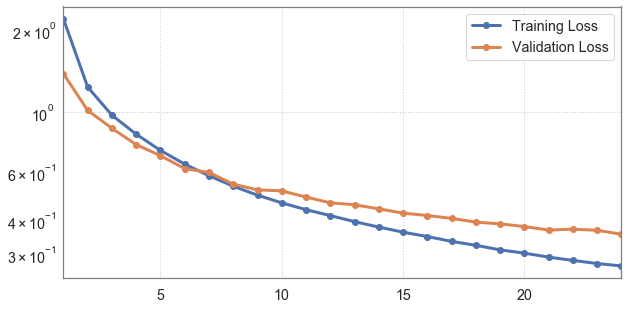

In [11]:
df = pd.DataFrame(history.history).rename({
    'loss':'Training Loss', 'val_loss':'Validation Loss'
},axis=1)

fig, ax1 = plt.subplots(1,1, figsize=(10,5))
df.iloc[1:][['Training Loss', 'Validation Loss']].plot(style='-o', ax=ax1, logy=True);
# plt.savefig("training.pdf")

## Out-of-sample predictions

In [12]:
# The predicted class is the one with the highest prob
preds = model.predict(X_trai)
preds = np.argmax(preds,axis=1)
reals = np.argmax(Y_trai,axis=1)
accuracy_in = np.mean(preds==reals)

preds = model.predict(X_test)
preds = np.argmax(preds,axis=1)
reals = np.argmax(Y_test,axis=1)
accuracy_out = np.mean(preds==reals)

print("In-sample accuracy:     {0:0.2f}%".format(accuracy_in*100))
print("Out-of-sample accuracy: {0:0.2f}%".format(accuracy_out*100))

In-sample accuracy:     92.53%
Out-of-sample accuracy: 91.32%


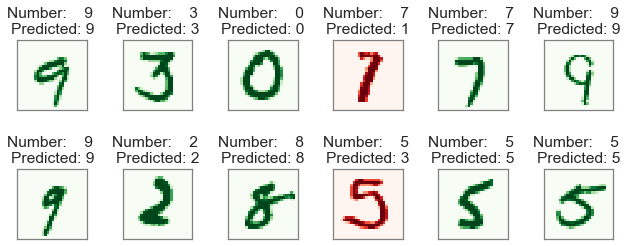

In [13]:
NX, NY = 2, 6
fig, ax = plt.subplots(NX,NY,figsize=(1.5*NY,2*NX))
for i in range(NX):
    for j in range(NY):
        s = np.random.randint(len(preds))
        img = x_test[s]
        colors = 'Greens' if reals[s]==preds[s] else 'Reds'
        ax[i][j].imshow(img, cmap=colors)
        ax[i][j].set_title("Number:    %d \nPredicted: %d"%(reals[s], preds[s]))
        ax[i][j].set_xticklabels([]); ax[i][j].set_xticks([])
        ax[i][j].set_yticklabels([]); ax[i][j].set_yticks([])
plt.tight_layout()
#plt.savefig("digits_preds_examples.pdf")

# Go Deeper
5 hidden layers

In [14]:
# Define the neural network

deep_model = Sequential("Deep Network")

deep_model.add(Dense(50, activation="relu", name='Hidden_Layer_1', input_dim=784))
deep_model.add(Dense(50, activation="relu", name='Hidden_Layer_2'))
deep_model.add(Dense(50, activation="relu", name='Hidden_Layer_3'))
deep_model.add(Dense(50, activation="relu", name='Hidden_Layer_4'))
deep_model.add(Dense(50, activation="relu", name='Hidden_Layer_5'))

deep_model.add(Dense(10, name="Output_Layer"))                  # 10 is the output dimension
deep_model.add(Activation("softmax", name='Output_Activation')) # Provides probabilities for each of 0,..,9
deep_model.compile(loss="categorical_crossentropy", optimizer=SGD(clipnorm=1), metrics=[categorical_accuracy] )

TypeError: The added layer must be an instance of class Layer. Found: D

In [ ]:
deep_model.summary()

In [ ]:
history = deep_model.fit(
    X_trai, Y_trai, validation_split=0.2,
    epochs=25, batch_size=128, verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_categorical_accuracy', patience=3, verbose=1, mode='auto')
    ],
)

In [ ]:
df = pd.DataFrame(history.history).rename({
    'loss':'Training Loss', 'val_loss':'Validation Loss',
},axis=1)
df.index = df.index + 1

fig, ax1 = plt.subplots(1,1, figsize=(10,5))
df.iloc[1:][['Training Loss', 'Validation Loss']].plot(style='-o', ax=ax1, logy=True);
# plt.savefig("training.pdf")

## Out-of-sample predictions

In [ ]:
# The predicted class is the one with the highest prob
preds = deep_model.predict(X_trai)
preds = np.argmax(preds,axis=1)
reals = np.argmax(Y_trai,axis=1)
accuracy_in = np.mean(preds==reals)

preds = deep_model.predict(X_test)
preds = np.argmax(preds,axis=1)
reals = np.argmax(Y_test,axis=1)
accuracy_out = np.mean(preds==reals)

print("In-sample accuracy:     {0:0.2f}%".format(accuracy_in*100))
print("Out-of-sample accuracy: {0:0.2f}%".format(accuracy_out*100))

In [ ]:
NX, NY = 2, 6
fig, ax = plt.subplots(NX,NY,figsize=(1.5*NY,2*NX))
for i in range(NX):
    for j in range(NY):
        s = np.random.randint(len(preds))
        img = x_test[s]
        colors = 'Greens' if reals[s]==preds[s] else 'Reds'
        ax[i][j].imshow(img, cmap=colors)
        ax[i][j].set_title("Number:    %d \nPredicted: %d"%(reals[s], preds[s]))
        ax[i][j].set_xticklabels([]); ax[i][j].set_xticks([])
        ax[i][j].set_yticklabels([]); ax[i][j].set_yticks([])
plt.tight_layout()
#plt.savefig("digits_preds_examples.pdf")

# Compare Models' Predictions

In [ ]:
preds_shal = model.predict(X_test)
preds_shal = np.argmax(preds_shal,axis=1)

preds_deep = deep_model.predict(X_test)
preds_deep = np.argmax(preds_deep,axis=1)

reals = np.argmax(Y_test,axis=1)

In [ ]:
df = pd.DataFrame({
    'real':reals,
    'pred_shal':preds_shal,
    'pred_deep':preds_deep,
})

df['ok_shal'] = (df['pred_shal'] == df['real'])
df['ok_deep'] = (df['pred_deep'] == df['real'])
df.head()

In [ ]:
improvements = df[df['ok_deep'] > df['ok_shal']].index

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,4))

s = np.random.choice(improvements,1)[0]
img = x_test[s]

fig.suptitle("Number: %d\n"%reals[s])
    
colors = 'Greens' if reals[s]==preds_deep[s] else 'Reds'
ax1.imshow(img, cmap=colors)
ax1.set_title(
    "Predicted (deep): %d "%(preds_deep[s])
)

colors = 'Greens' if reals[s]==preds_shal[s] else 'Reds'
ax2.imshow(img, cmap=colors)
ax2.set_title(
    "Predicted (shallow): %d"%(preds_shal[s])
)

ax1.set_xticklabels([]); ax1.set_xticks([])
ax1.set_yticklabels([]); ax1.set_yticks([])

ax2.set_xticklabels([]); ax2.set_xticks([])
ax2.set_yticklabels([]); ax2.set_yticks([])

plt.tight_layout()

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>